In [1]:
import torch
from diffusers import DDPMPipeline
from genaibook.core import get_device

/Users/jorocca/Desktop/Projects/AI Practice/Transformers-Diffusions/.venv/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [2]:
device = get_device()

In [3]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /Users/jorocca/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/jorocca/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

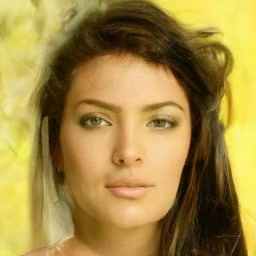

In [4]:
image_pipe().images[0]

In [5]:
from genaibook.core import plot_noise_and_denoise

In [6]:
image = torch.randn(4, 3, 256, 256).to(device)

In [7]:
image_pipe.scheduler.set_timesteps(num_inference_steps=30)

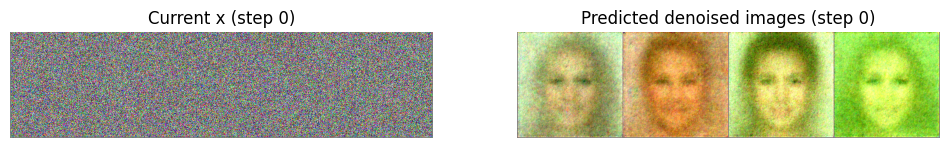

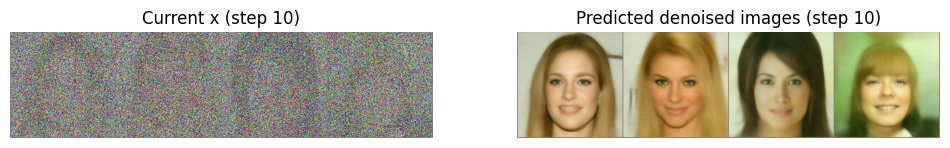

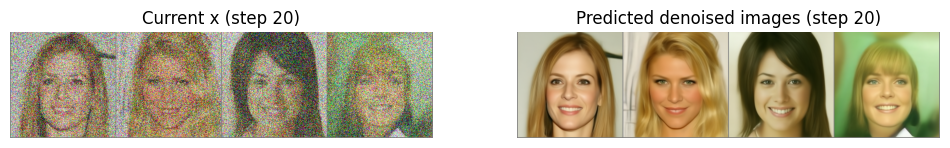

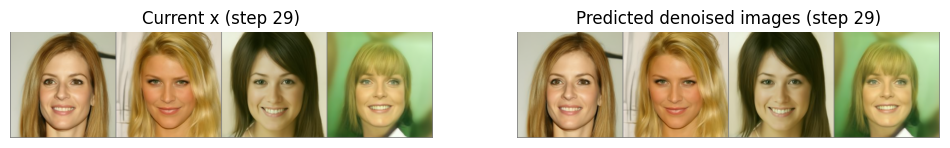

In [8]:
for i, t in enumerate(image_pipe.scheduler.timesteps):
    with torch.inference_mode():
        noise_pred = image_pipe.unet(image, t)['sample']
        scheduler_output = image_pipe.scheduler.step(noise_pred, t, image)
        image = scheduler_output.prev_sample
        if i % 10 == 0 or i == len(image_pipe.scheduler.timesteps) - 1:
            plot_noise_and_denoise(scheduler_output, i)

In [9]:
from datasets import load_dataset

In [10]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [11]:
from torchvision import transforms

In [12]:
image_size=64

In [13]:
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)), # resize
    transforms.RandomHorizontalFlip(), # Randomly flip data to make model more robust (data augmentation)
    transforms.ToTensor(), # make tensor (0, 1)
    transforms.Normalize([0.5], [0.5]) # Map to (-1, 1)
])

In [14]:
def transform(examples):
    examples = [preprocess(image) for image in examples['image']]
    return {"images": examples}

In [15]:
dataset.set_transform(transform)
batch_size=16

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [16]:
from genaibook.core import show_images

In [17]:
batch = next(iter(train_dataloader))

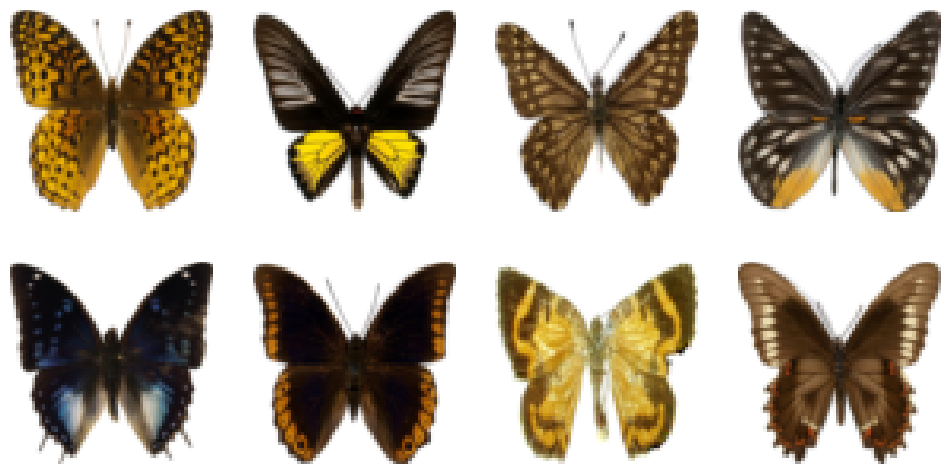

In [18]:
show_images(batch['images'][:8] * 0.5 + 0.5)

## add noise

In [19]:
from diffusers import DDPMScheduler

In [20]:
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.02)
timesteps = torch.linspace(0, 999, 8).long() # tensor with 8 evenly spaced values from 0 to 999

In [21]:
x = batch['images'][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

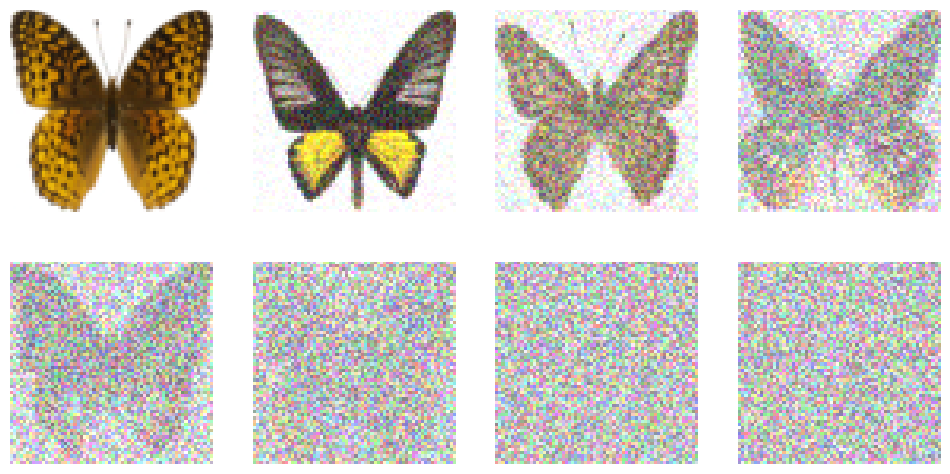

In [22]:
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

## make model

In [23]:
from diffusers import UNet2DModel

In [24]:
model = UNet2DModel(
    in_channels=3,
    sample_size=64,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
).to(device)

In [25]:
with torch.inference_mode():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample
    print(noised_x.shape)
    print(out.shape)

torch.Size([8, 3, 64, 64])
torch.Size([8, 3, 64, 64])


## train model

In [26]:
from torch.nn import functional as F

In [27]:
num_epochs = 50
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []

In [28]:
for epoch in range(num_epochs):
    for batch in train_dataloader:
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

## plot training loss

In [29]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'Training step')

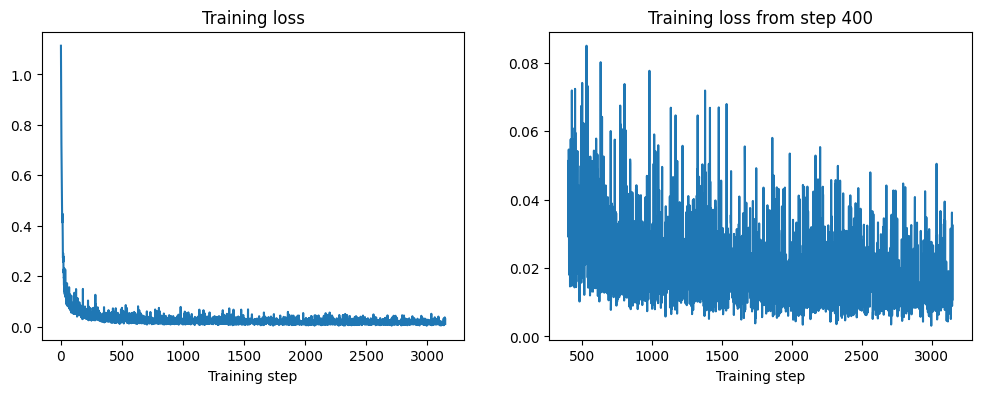

In [ ]:
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step")

# sampling

  0%|          | 0/1000 [00:00<?, ?it/s]

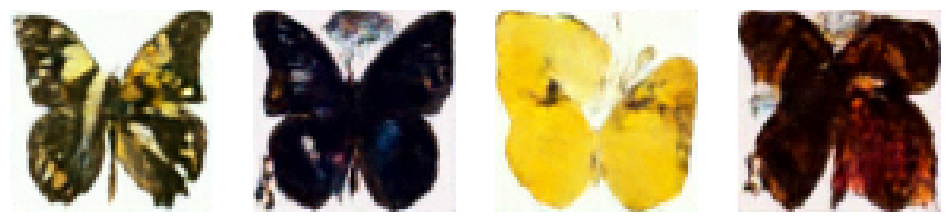

In [31]:
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images
show_images(ims, nrows=1)

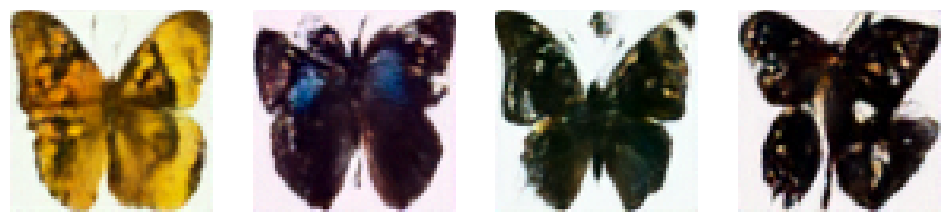

In [32]:
sample = torch.randn(4, 3, 64, 64).to(device)

for t in scheduler.timesteps:
    with torch.inference_mode():
        noise_pred = model(sample, t)['sample']

        sample = scheduler.step(noise_pred, t, sample).prev_sample

show_images(sample.clip(-1, 1) * 0.5 + 0.5, nrows=1)

# Exploring Noise

## Continous Time Approach

In [33]:
x = next(iter(train_dataloader))['images'][:8]
noise = torch.rand_like(x)

In [34]:
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)
    return (
        x * (1 - amount) + noise * amount
    )

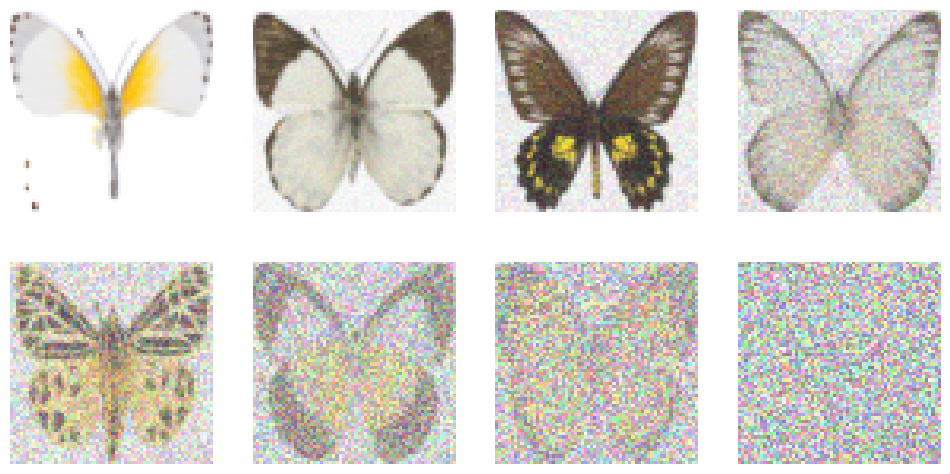

In [35]:
amount = torch.linspace(0, 1, 8)
noised_x = corrupt(x, noise, amount)
show_images(noised_x * 0.5 + 0.5)

## Discrete Time Approach

In [36]:
class SimpleScheduler:
    def __init__(self):
        self.num_train_timesteps = 1000

    def add_noise(self, x, noise, timesteps):
        amount = timesteps/ self.num_train_timesteps
        return corrupt(x, noise, amount)

In [37]:
scheduler = SimpleScheduler()

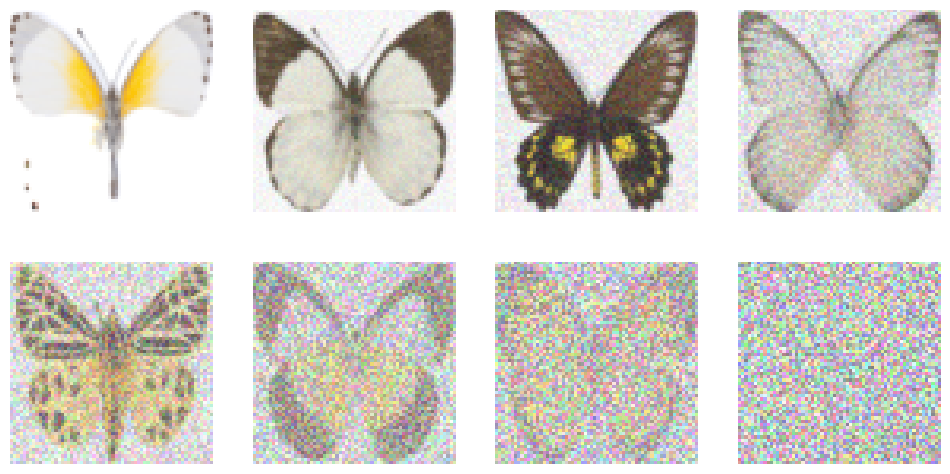

In [38]:
timesteps = torch.linspace(0, 999, 8).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images(noised_x * 0.5 + 0.5)

## Compare To Diffusers

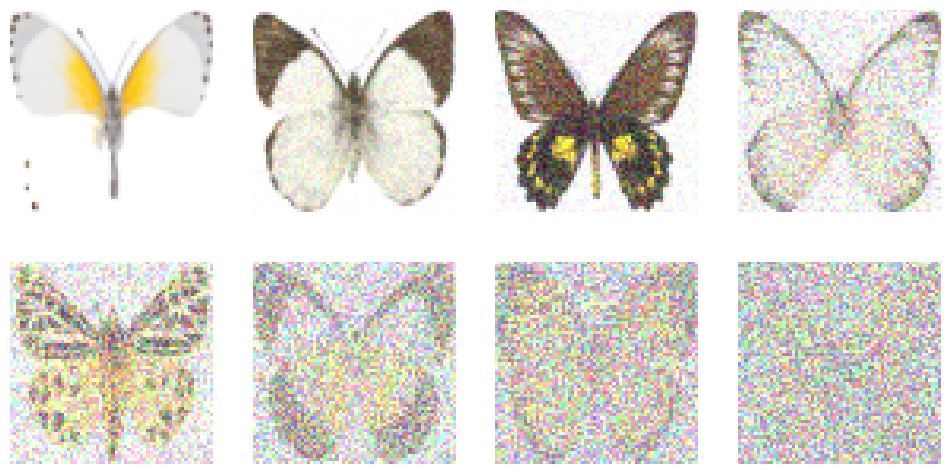

In [39]:
scheduler = DDPMScheduler(beta_end=0.01)
timesteps = torch.linspace(0, 999, 8).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [40]:
from genaibook.core import plot_scheduler

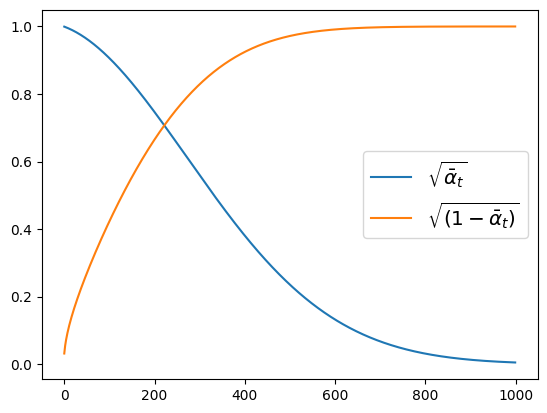

In [41]:
plot_scheduler(DDPMScheduler(beta_start=0.001, beta_end=0.02, beta_schedule="linear"))

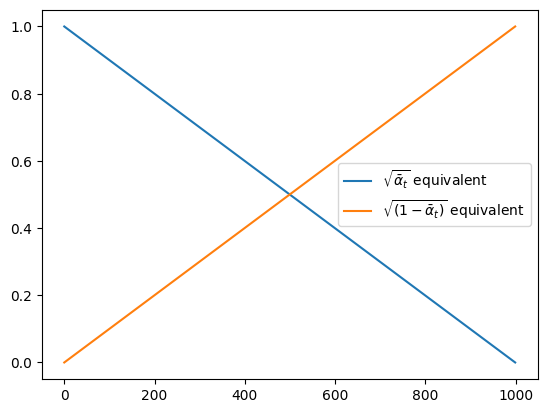

In [42]:
plot_scheduler(SimpleScheduler())

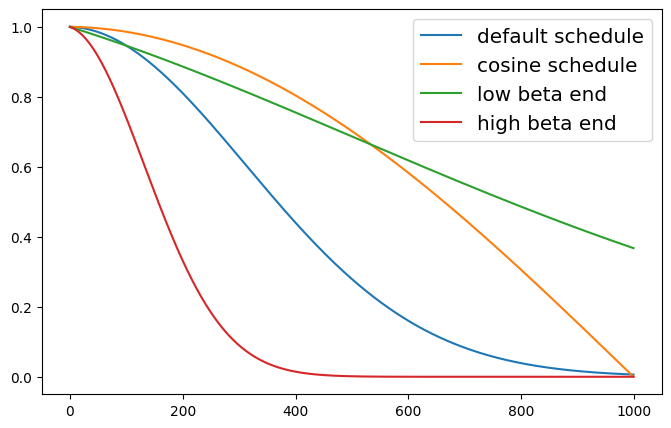

In [43]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 5))
plot_scheduler(
    DDPMScheduler(beta_schedule="linear"),
    label="default schedule",
    ax=ax,
    plot_both=False
)
plot_scheduler(
    DDPMScheduler(beta_schedule="squaredcos_cap_v2"),
    label="cosine schedule",
    ax=ax,
    plot_both=False
)
plot_scheduler(
    DDPMScheduler(
        beta_start=0.001,
        beta_end=0.003,
        beta_schedule="linear"
    ),
    label="low beta end",
    ax=ax,
    plot_both=False
)
plot_scheduler(
    DDPMScheduler(
        beta_start=0.001, beta_end=0.1, beta_schedule="linear"
    ),
    label="high beta end",
    ax=ax,
    plot_both=False
    )


In [44]:
import numpy as np
from genaibook.core import SampleURL, load_image

In [45]:
scheduler = DDPMScheduler(beta_end=0.05, beta_schedule="scaled_linear")

In [46]:
image = load_image(
    SampleURL.DogExample,
    size=((512, 512)),
    return_tensor=True
)

In [47]:
t = torch.tensor(300)
scales = np.linspace(0.1, 1.0, 4)
images = [image]
noise = torch.randn_like(image)

In [48]:
for b in reversed(scales):
    noised = (
        scheduler.add_noise(b * (image * 2 - 1), noise, t).clip(-1, 1) * 0.5
    )
    images.append(noised)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..0.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..0.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..0.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..0.5].


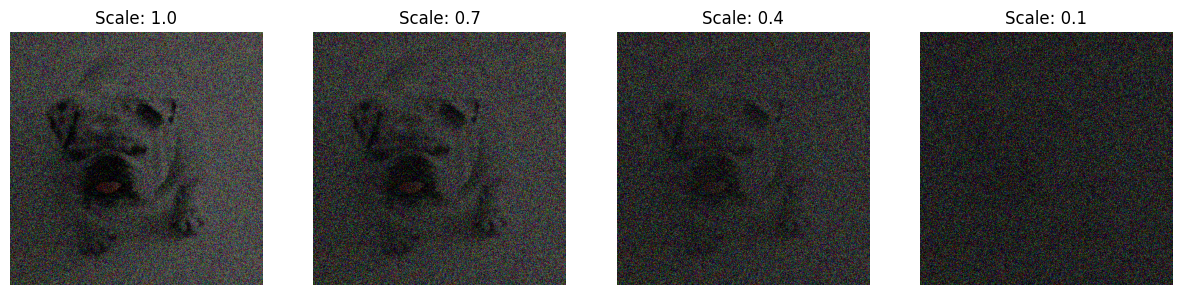

In [49]:
show_images(
    images[1:],
    nrows=1,
    titles=[f'Scale: {b}' for b in reversed(scales)],
    figsize=(15, 5)
)

## UNets

In [50]:
from torch import nn

In [51]:
class BasicUNet(nn.Module):
    # Minimal Implementation

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2)
            ]
        )
        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
            ]
        )
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x) # Sort output for skip connection
                x = self.downscale(x)

        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop() # Fetching skip connection
            x = self.act(l(x))

        return x


In [52]:
from datasets import load_dataset

In [53]:
dataset = load_dataset("mnist")

In [54]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

In [55]:
image_size = 32
torch_size = 8

In [56]:
def transform(examples):
    examples = [preprocess(image) for image in examples['image']]
    return {"images": examples}

In [57]:
dataset.set_transform(transform)

In [58]:
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ]
)

In [59]:
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)

In [60]:
import torchvision
from matplotlib import pyplot as plt

Input Shape: torch.Size([16, 1, 32, 32])


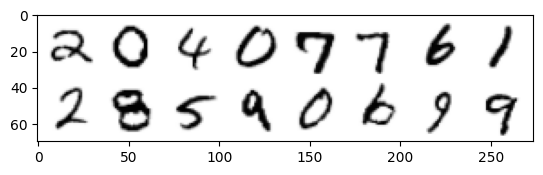

In [61]:
imgs = next(iter(train_dataloader))['images']
print("Input Shape:", imgs.shape)
plt.imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys")

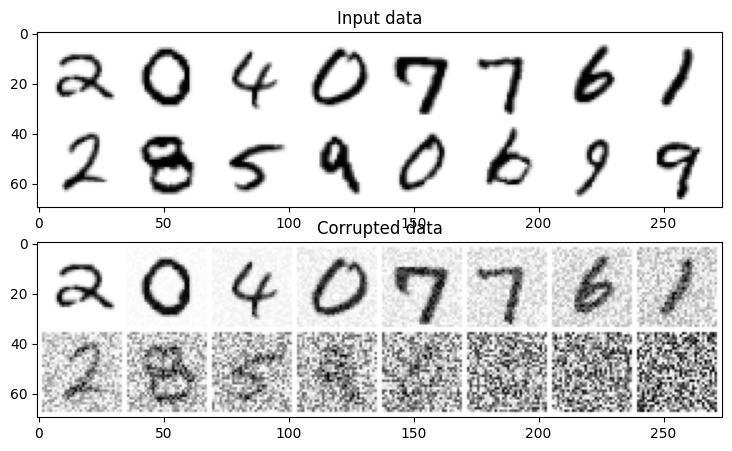

In [62]:
# Corruption
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys")

amount = torch.linspace(0, 1, imgs.shape[0])
noise = torch.rand_like(imgs)
noised_x = corrupt(imgs, noise, amount)

axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [63]:
# Add UNet
net = BasicUNet()
x = torch.rand(8, 1, 32, 32)
net(x).shape

torch.Size([8, 1, 32, 32])

In [64]:
# Train model
from torch.nn import functional as F
device = get_device()
num_epochs = 5
batch_size = 128

In [65]:
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)

In [66]:
model = BasicUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

In [67]:
for epoch in range(num_epochs):
    for batch in train_dataloader:
        clean_images = batch['images'].to(device)
        noise = torch.rand_like(clean_images).to(device)
        noise_amount = torch.randn(clean_images.shape[0]).to(device)
        noisy_x = corrupt(clean_images, noise, noise_amount)
        pred = model(noisy_x)
        loss = F.mse_loss(pred, clean_images)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.016117
Finished epoch 1. Average loss for this epoch: 0.010357
Finished epoch 2. Average loss for this epoch: 0.009293
Finished epoch 3. Average loss for this epoch: 0.008941
Finished epoch 4. Average loss for this epoch: 0.008601


In [68]:
n_steps = 5
x = torch.rand(8, 1, 32, 32).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

In [69]:
for i in range(n_steps):
    with torch.no_grad():
        pred = model(x)

    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
    step_history.append(x.detach().cpu())

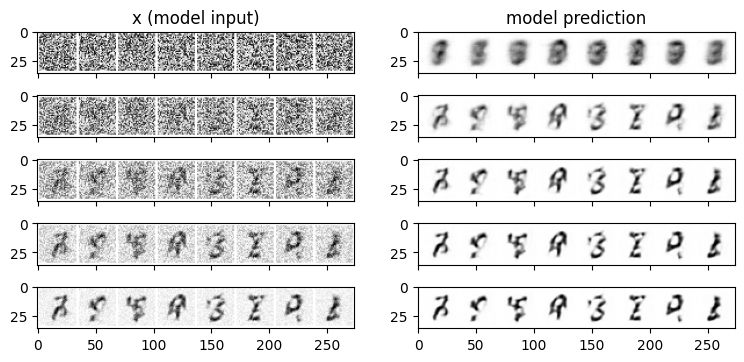

In [70]:
fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")

awful

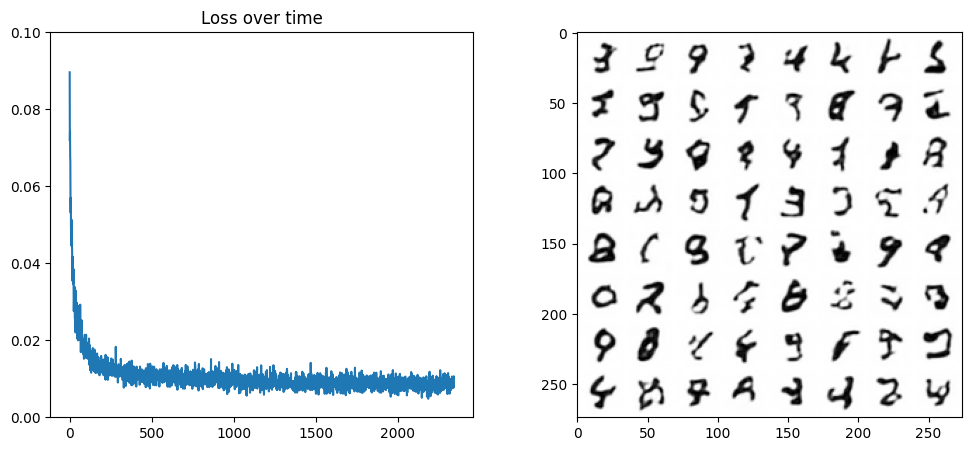

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

n_steps = 40
x = torch.rand(64, 1, 32, 32).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )
    with torch.no_grad():
        pred = model(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys"
)

just horrible results 😂

In [72]:
basic_losses = losses
basic_model = model

## Compare to diffusers UNet

In [73]:
from diffusers import UNet2DModel

In [74]:
model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2, # How many ResNet layers to use per block
    block_out_channels=(32, 64, 64), # matches example made above
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D"
    )
).to(device)

In [75]:
sum(
    [p.numel() for p in model.parameters()]
)

1707009

In [76]:
# Train model - big so longer than above
batch_size=32
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
num_epochs = 5
opts = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

In [77]:
for epoch in range(num_epochs):
    for batch in train_dataloader:
        clean_images = batch["images"].to(device)
        noise = torch.rand_like(clean_images).to(device)
        noise_amount = torch.randn(clean_images.shape[0]).to(device)
        noisy_x = corrupt(clean_images, noise, noise_amount)
        pred = model(noisy_x, 0).sample
        loss = F.mse_loss(pred, clean_images)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}'
    )

Finished epoch 0. Average loss for this epoch: 0.217855
Finished epoch 1. Average loss for this epoch: 0.217975
Finished epoch 2. Average loss for this epoch: 0.217939
Finished epoch 3. Average loss for this epoch: 0.217861
Finished epoch 4. Average loss for this epoch: 0.217922


Text(0.5, 1.0, 'Generated Samples')

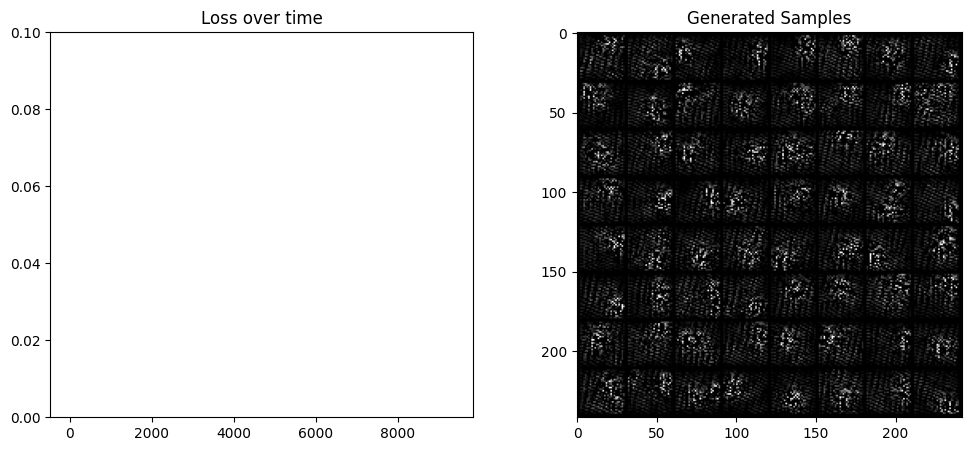

In [78]:
# Plot things
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="grey"
)
axs[1].set_title("Generated Samples")

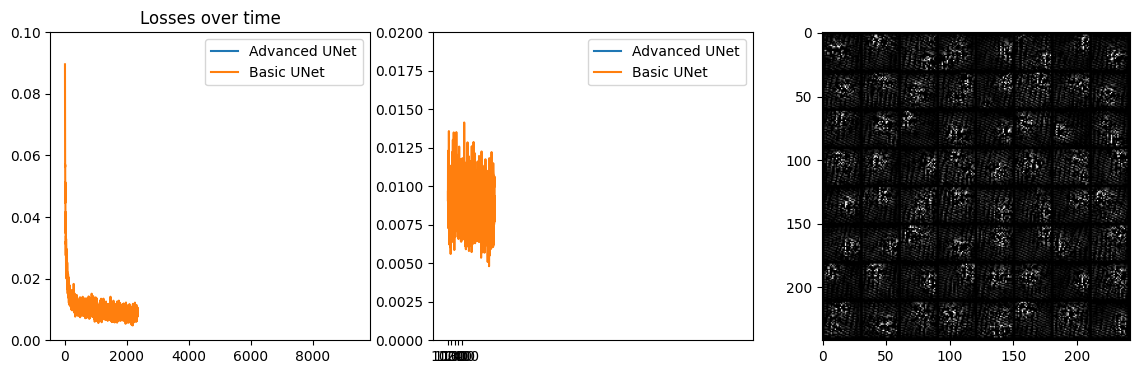

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
import numpy as np

axs[0].plot(losses, label="Advanced UNet")
axs[0].plot(basic_losses, label="Basic UNet")
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Losses over time")
axs[0].legend()

axs[1].plot(losses[1000:14000], label="Advanced UNet")
axs[1].plot(basic_losses[1000:14000], label="Basic UNet")
axs[1].set_ylim(0, 0.02)
axs[1].set_xticks(np.arange(0, 401, step=100), np.arange(1000, 1401, step=100))
axs[1].legend()

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[2].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="grey"
)

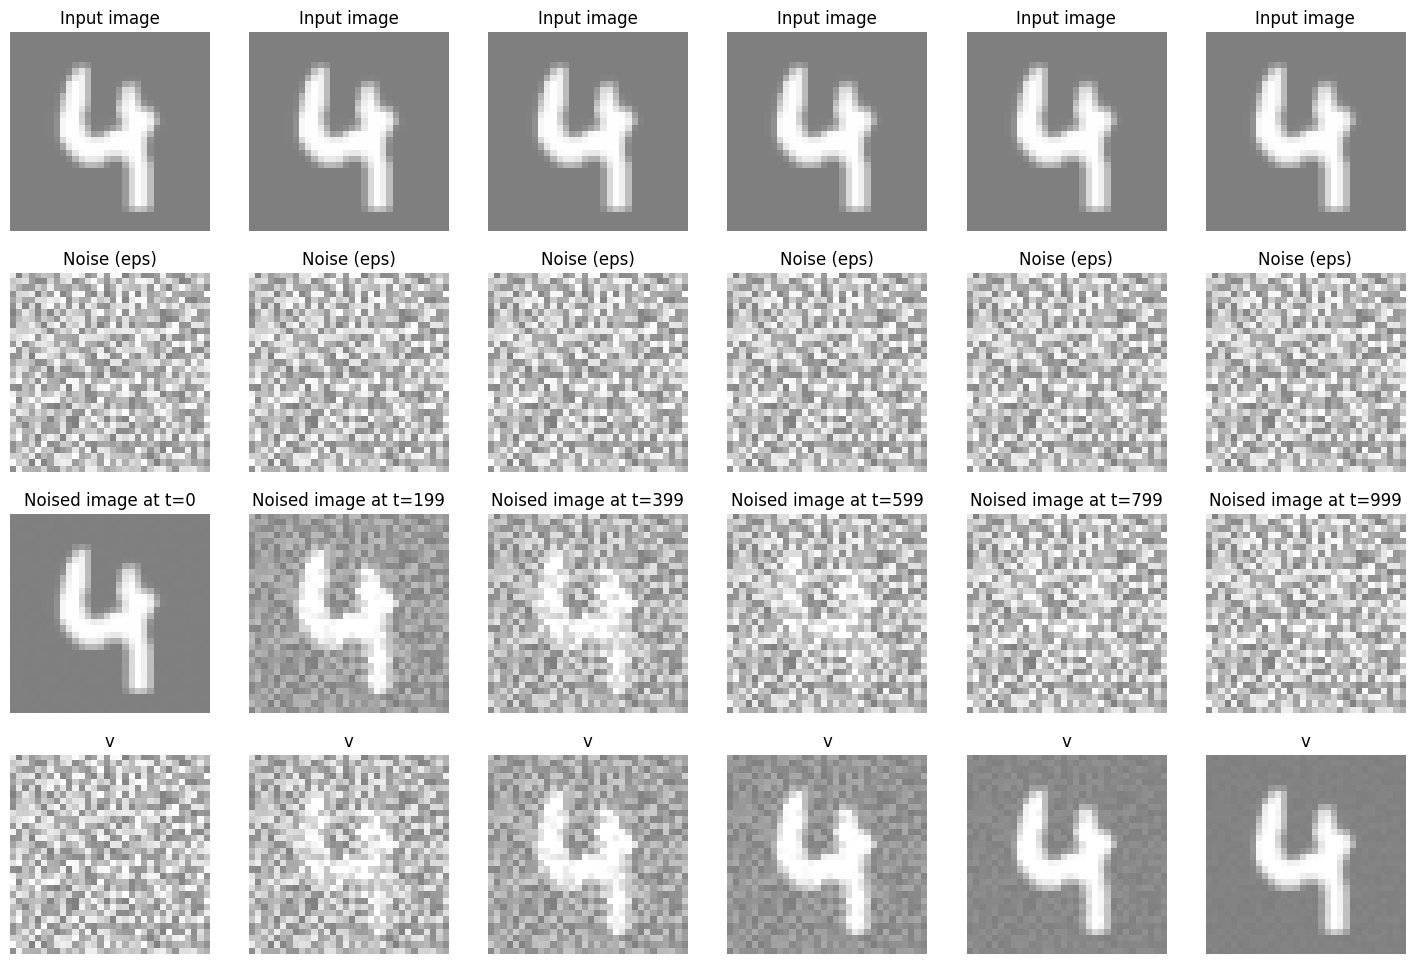

In [82]:
scheduler = DDPMScheduler(beta_end=0.012)
sample = batch['images'][0]
image_size = sample.shape[-1]
noise_size = image_size # 32
res_transform = transforms.Resize(noise_size, antialias=True)
x = res_transform(sample.expand(6, 3, image_size, image_size))
noise = torch.rand_like(res_transform(sample)).expand(6, 3, noise_size, noise_size)
timesteps = torch.linspace(0, 999, 6).long()
noised_x = scheduler.add_noise(x, noise, timesteps)
alpha_bars = scheduler.alphas_cumprod[timesteps]
v = (
    alpha_bars.view(-1, 1, 1, 1).sqrt() * noise
    + (1 - alpha_bars.view(-1, 1, 1, 1)).sqrt() * x
)
images = torch.cat(
    [
        x,
        noise,
        noised_x,
        v,
    ],
    dim=0
)
titles = (
    ["Input image"] * 6
    + ["Noise (eps)"] * 6
    + [f"Noised image at t={t}" for t in timesteps]
    + ["v"] * 6
)

show_images(images.clip(-1, 1) * 0.5 + 0.5, ncols=6, titles=titles)